# Blood Group Detection from Fingerprint using EfficientNetB0 Model

#### Import the required libraries

In [1]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import zipfile
import warnings
warnings.filterwarnings('ignore')

#### Download and unzip the dataset

In [2]:
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset

Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset
License(s): unknown
 96% 56.0M/58.1M [00:03<00:00, 23.8MB/s]
100% 58.1M/58.1M [00:03<00:00, 16.1MB/s]


In [3]:
zip_ref = zipfile.ZipFile('/content/finger-print-based-blood-group-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

#### Data preprocessing

In [4]:
file_path = '/content/dataset_blood_group'

In [5]:
data = pd.DataFrame({
    'Filepath': glob.glob(file_path + "/*/*"),
    'Label': [os.path.basename(os.path.dirname(fp)) for fp in glob.glob(file_path + "/*/*")]
})

Splitting the dataset into train and test sets

In [6]:
train, test = train_test_split(data, test_size=0.20, random_state=42, stratify=data["Label"])

#### Image data augmentation

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4800 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


#### Model architecture

In [8]:
pretrained_model = EfficientNetB0(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,231,083 (16.14 MB)

 Trainable params: 181,512 (709.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

#### Model training

In [10]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 142ms/step - accuracy: 0.3528 - loss: 1.6655 - val_accuracy: 0.5642 - val_loss: 1.0881
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.5695 - loss: 1.0750 - val_accuracy: 0.6250 - val_loss: 0.9183
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6437 - loss: 0.8877 - val_accuracy: 0.6525 - val_loss: 0.8709
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6772 - loss: 0.8186 - val_accuracy: 0.6792 - val_loss: 0.7848
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6883 - loss: 0.7698 - val_accuracy: 0.7025 - val_loss: 0.7463
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7136 - loss: 0.7023 - val_accuracy: 0.7308 - val_loss: 0.6681
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.7378 - loss: 0.6519 - val_accuracy: 0.6592 - val_loss: 0.8271
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7689 - loss: 0.6156 - va

#### Saving the model

In [11]:
model.save("efficientnetb0.h5")

#### Model evaluation

In [12]:
name_class = sorted(os.listdir(file_path))
pred = model.predict(valid_gen)
pred_labels = np.argmax(pred, axis=1)
true_labels = valid_gen.classes

print(classification_report(true_labels, pred_labels, target_names=name_class))

38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step
              precision    recall  f1-score   support

          A+       0.80      0.87      0.83       113
          A-       0.78      0.63      0.70       202
         AB+       0.74      0.85      0.79       142
         AB-       0.80      0.66      0.72       152
          B+       0.76      0.80      0.78       130
          B-       0.76      0.96      0.85       148
          O+       0.64      0.79      0.71       171
          O-       0.89      0.56      0.68       142

    accuracy                           0.76      1200
   macro avg       0.77      0.76      0.76      1200
weighted avg       0.77      0.76      0.75      1200



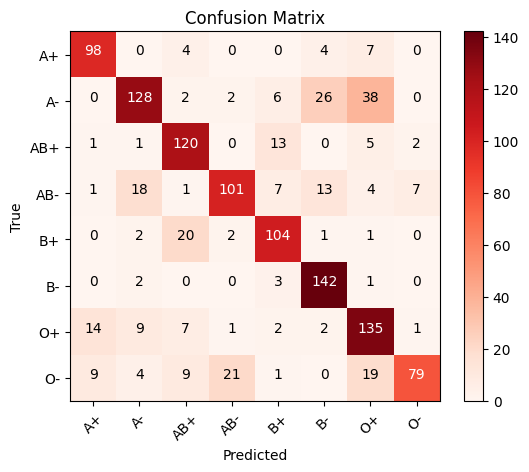

In [13]:
cm = confusion_matrix(true_labels, pred_labels)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(name_class))
plt.xticks(tick_marks, name_class, rotation=45)
plt.yticks(tick_marks, name_class)

for i in range(len(name_class)):
    for j in range(len(name_class)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Visualizing accuracy and loss over epochs

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

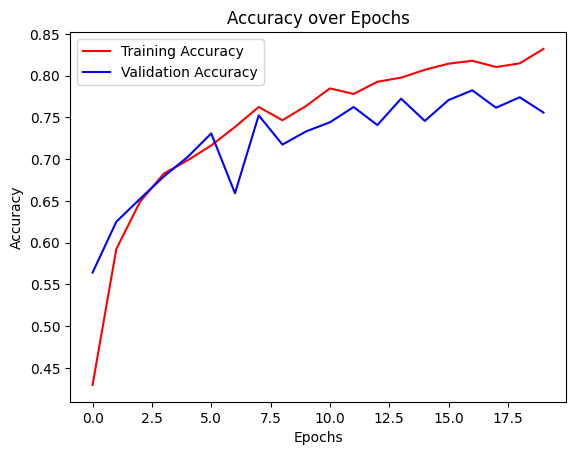

In [15]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

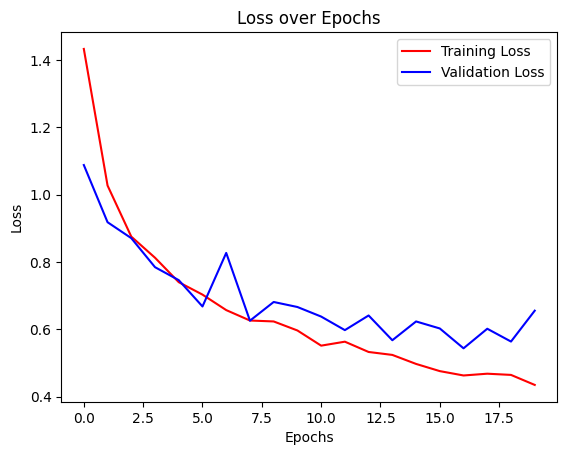

In [16]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model prediction

In [17]:
class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

def predict_blood_group(image_path, model, class_names):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    confidence_score = np.max(predictions) * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2f}%", fontsize=14, color='black')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


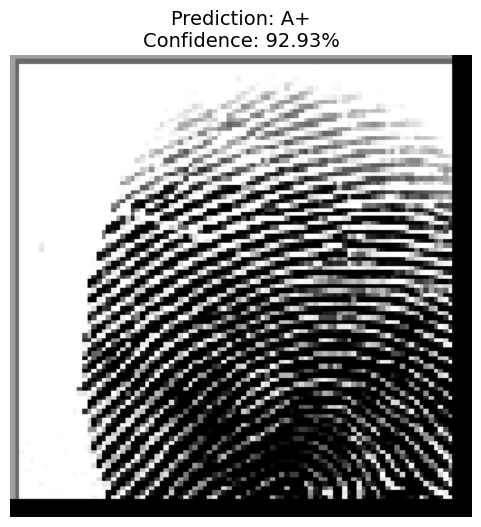

In [18]:
image_path = '/content/dataset_blood_group/A+/cluster_0_1001.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


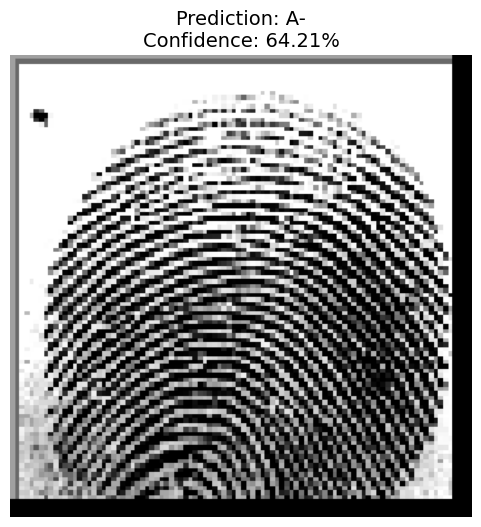

In [19]:
image_path = '/content/dataset_blood_group/A-/cluster_1_1007.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


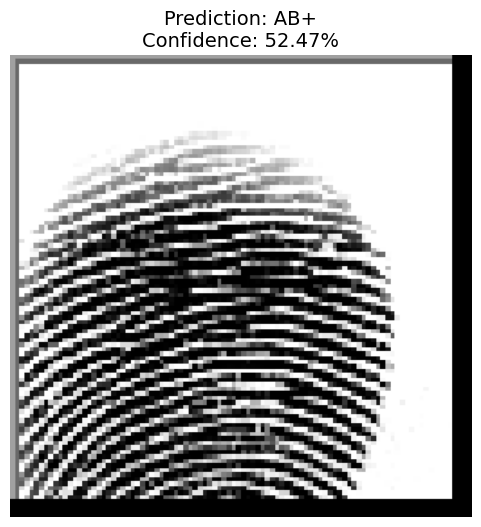

In [20]:
image_path = '/content/dataset_blood_group/AB+/cluster_4_100.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


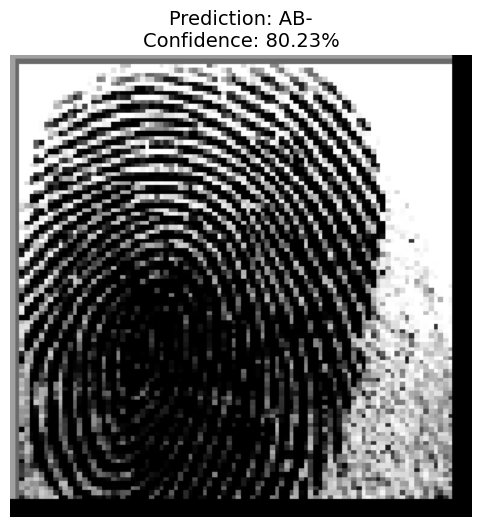

In [31]:
image_path = '/content/dataset_blood_group/AB-/cluster_5_1013.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


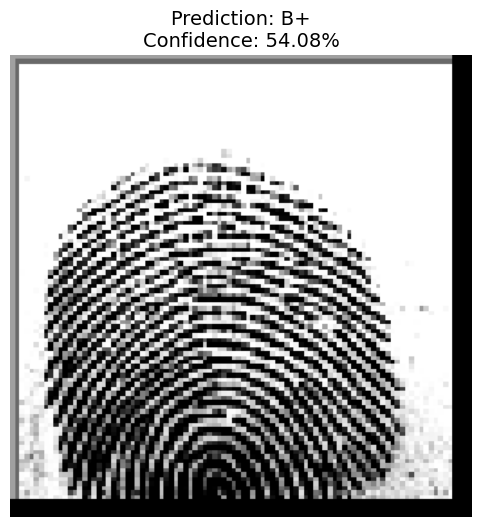

In [22]:
image_path = '/content/dataset_blood_group/B+/cluster_2_1077.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


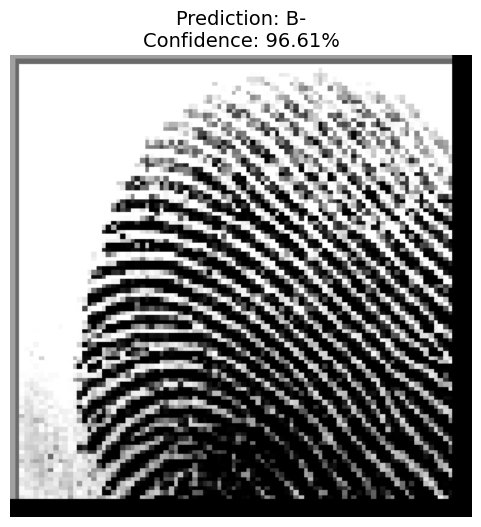

In [23]:
image_path = '/content/dataset_blood_group/B-/cluster_3_1018.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


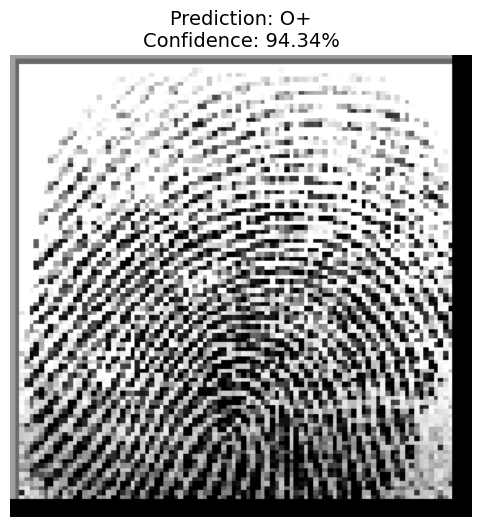

In [24]:
image_path = '/content/dataset_blood_group/O+/cluster_6_1004.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


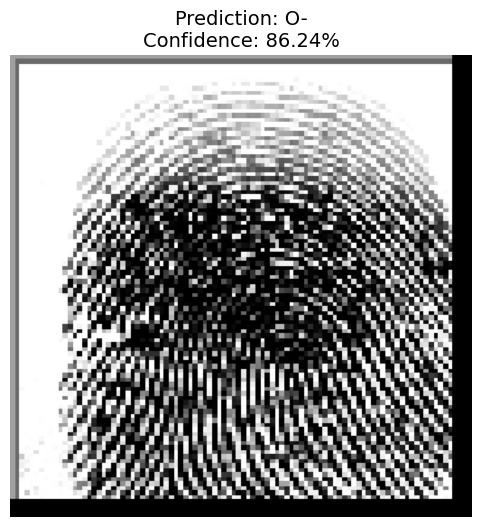

In [29]:
image_path = '/content/dataset_blood_group/O-/cluster_7_1028.BMP'
predict_blood_group(image_path, model, class_names)